# Cluster Configuration + Imports

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.235.29:8786")
client

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Connection method: Direct,
Dashboard: /user/jannicke.pearkes@cern.ch/proxy/8787/status,
Comm: tls://192.168.235.29:8786,Workers: 0
Dashboard: /user/jannicke.pearkes@cern.ch/proxy/8787/status,Total threads: 0
Started: 1 day ago,Total memory: 0 B


In [2]:
import hist
import time
import json
import dask
import operator
import numba
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import normalize
from pprint import pprint
from itertools import combinations, combinations_with_replacement
from collections import defaultdict

import awkward as ak
import dask_awkward as dak
import hist.dask as hda
import vector
vector.register_awkward()

from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import coffea.processor as processor
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

/tmp/ipykernel_343572/3667554185.py:21: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


# Coffea Histogram Processor

In [3]:
def find_diObjs(events_obj_coll, isL1):
    if isL1:
        rest_mass_dict = {'L1Jet':0, 'L1Mu':0, 'L1EG':0}
        objs = ak.zip(
            {
                "pt": events_obj_coll.pt,
                "eta": events_obj_coll.eta,
                "phi": events_obj_coll.phi,
                "mass": ak.zeros_like(events_obj_coll.pt),
            },
            with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior,
        )
        
        diObjs = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj = ak.zip(
            {
                "p4": diObjs.obj1+diObjs.obj2,
            },
        )
        
        diObj["mass"] = np.sqrt(2*diObjs.obj1.pt*diObjs.obj2.pt*(np.cosh(diObjs.obj1.eta-diObjs.obj2.eta)-np.cos(diObjs.obj1.phi-diObjs.obj2.phi)))

    else:
        objs = ak.zip({ 
            k: getattr(events_obj_coll, k) for k in ["x", "y", "z", "t"] }, 
            with_name="LorentzVector", 
            behavior=events_obj_coll.behavior, 
        )

        diObj = dak.combinations(objs, 2, fields=["obj1", "obj2"])
        diObj["p4"] = diObj.obj1 + diObj.obj2
        diObj["mass"] = diObj.p4.mass

    return diObj

    
class MakeAXOHists (processor.ProcessorABC):
    def __init__(self, trigger_paths=[], extra_cut='', thresholds=None, object_dict=None):
        self.run_dict = {
            'thresholds' : thresholds if thresholds is not None else {
                'AXOVTight_EMU'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
                'AXOTight_EMU'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
                'AXONominal_EMU' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
                'AXOLoose_EMU'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
                'AXOVLoose_EMU'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
            },
            'objects' : object_dict if object_dict is not None else {
                        'Jet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                        'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                        'Muon' :     {'cut' : [('pt', 10)], 'label' : '\mu'},
                        'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                        'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                        'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'},
                       }
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'],key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_paths = trigger_paths
        self.extra_cut = extra_cut
        
        self.dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        self.score_axis = hist.axis.Regular(100, 0, 4000, name="score", label='Anomaly Score')
        self.mult_axis = hist.axis.Regular(100,0,100, name="mult", label=r'$N_{obj}$')
        self.pt_axis = hist.axis.Regular(200,0,5000, name="pt", label=r"$p_{T}$ [GeV]")
        self.eta_axis = hist.axis.Regular(150,-5,5, name="eta", label=r"$\eta$")
        self.phi_axis = hist.axis.Regular(30,-4,4, name="phi", label=r"$\phi$")
        self.met_axis = hist.axis.Regular(250,0,2500, name="met", label=r"$p^{miss}_{T} [GeV]$")
        self.ht_axis = hist.axis.Regular(100,0,2000, name="ht", label=r"$H_{T}$ [GeV]")
        self.minv_axis = hist.axis.Regular(600,0,3000, name="minv", label=r"$m_{obj_{1},obj_{2}}$ [GeV]")

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
        hist_dict = {}
        
        # Saturated-Jets event cut
        events = events[dak.all(events.L1Jet.pt<1000,axis=1)]
        # Saturated-MET event cut
        events = events[dak.flatten(events.L1EtSum.pt[(events.L1EtSum.etSumType==2) & (events.L1EtSum.bx==0)])<1040]
 
        # Get scalar branches
        axo = events.axol1tl
        l1_etsums = events.L1EtSum
        l1_ht = l1_etsums[(events.L1EtSum.etSumType==1) & (events.L1EtSum.bx==0)]
        l1_met = l1_etsums[(events.L1EtSum.etSumType==2) & (events.L1EtSum.bx==0)]
        l1_total_mult = ak.num(events.L1Jet) + ak.num(events.L1Mu) + ak.num(events.L1EG)
        l1_total_pt = ak.sum(events.L1Jet.pt,axis=1) + ak.sum(events.L1Mu.pt,axis=1) + ak.sum(events.L1EG.pt,axis=1)

        # Fill 1D scalar histograms
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0)
        hist_dict['anomaly_score'] = h_score

        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
        hist_dict[f'anomaly_score_unpf'] = h_score
        
        h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
        h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
        hist_dict[f'anomaly_score_unpf_firstbx'] = h_score
        
        h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
        h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
        hist_dict['l1ht'] = h_l1ht                              

        h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
        h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
        hist_dict['l1met'] = h_l1met
        
        h_total_l1mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
        h_total_l1mult.fill(dataset=dataset, mult=l1_total_mult)
        hist_dict['total_l1mult'] = h_total_l1mult
        
        h_total_l1pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
        h_total_l1pt.fill(dataset=dataset, pt=l1_total_pt)
        hist_dict['total_l1pt'] = h_total_l1pt

        # Fill 2D scalar histograms
        h_score_l1ht = hda.hist.Hist(self.dataset_axis, self.score_axis, self.ht_axis, storage="weight", label="nEvents")
        h_score_l1ht.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_ht.pt)[0]), ht=ak.flatten(l1_ht.pt))
        hist_dict['anomaly_score_l1ht'] = h_score_l1ht                              

        h_score_l1met = hda.hist.Hist(self.dataset_axis, self.score_axis, self.met_axis, storage="weight", label="nEvents")
        h_score_l1met.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), met=ak.flatten(l1_met.pt))
        hist_dict['anomaly_score_l1met'] = h_score_l1met
        
        h_score_total_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
        h_score_total_mult.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), mult=l1_total_mult)
        hist_dict['anomaly_score_total_mult'] = h_score_total_mult
        
        h_score_total_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
        h_score_total_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), pt=l1_total_pt)
        hist_dict['anomaly_score_total_pt'] = h_score_total_pt

        # Process object collections
        for obj,obj_dict in self.run_dict['objects'].items():
            cut_list = obj_dict['cut']
            label = obj_dict['label']
            isL1Obj = 'L1' in obj
            br = getattr(events, obj)

            # Filter only L1 Objects from BX==0
            if isL1Obj:
                br = br[br.bx==0]

            # Apply list of cuts to relevant branches
            for var, cut in cut_list:
                mask = (getattr(br,var) > cut)
            
            # Build di-object candidate
            objs = br[ak.argsort(br.pt, axis=1)]
            diObj = find_diObjs(objs, isL1Obj)
            
            # Fill 1D histograms
            h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
            h_mult.fill(dataset=dataset, mult=dak.num(br))
            hist_dict[f'n_{obj}'] = h_mult

            h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
            h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
            hist_dict[f'pt_{obj}'] = h_pt

            h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
            h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
            hist_dict[f'eta_{obj}'] = h_eta

            h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
            h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
            hist_dict[f'phi_{obj}'] = h_phi

            h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
            h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
            hist_dict[f'm{obj}{obj}'] = h_minv

            # Fill 2D histograms
            h_eta_phi = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.phi_axis, storage="weight", label="nEvents")
            h_eta_phi.fill(dataset=dataset, eta=dak.flatten(br.eta), phi=dak.flatten(br.phi))
            hist_dict[f'eta_phi_{obj}'] = h_eta_phi            

            h_score_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
            h_score_mult.fill(dataset=dataset, score=axo.score_bx0, mult=dak.num(br))
            hist_dict[f'anomaly_score_n_{obj}'] = h_score_mult

            h_score_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
            h_score_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.pt)[0]), pt=dak.flatten(br.pt))
            hist_dict[f'anomaly_score_pt_{obj}'] = h_score_pt
            
            h_score_eta = hda.hist.Hist(self.dataset_axis, self.score_axis, self.eta_axis, storage="weight", label="nEvents")
            h_score_eta.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.eta)[0]), eta=dak.flatten(br.eta))
            hist_dict[f'anomaly_score_eta_{obj}'] = h_score_eta
            
            h_score_phi = hda.hist.Hist(self.dataset_axis, self.score_axis, self.phi_axis, storage="weight", label="nEvents")
            h_score_phi.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.phi)[0]), phi=dak.flatten(br.phi))
            hist_dict[f'anomaly_score_phi_{obj}'] = h_score_phi
            
            h_score_minv = hda.hist.Hist(self.dataset_axis, self.score_axis, self.minv_axis, storage="weight", label="nEvents")
            h_score_minv.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,diObj.mass)[0]), minv=dak.flatten(diObj.mass))
            hist_dict[f'anomaly_score_m{obj}{obj}'] = h_score_minv
            
            h_mult_eta = hda.hist.Hist(self.dataset_axis, self.mult_axis, self.eta_axis, storage="weight", label="nEvents")
            h_mult_eta.fill(dataset=dataset, mult=dak.flatten(ak.broadcast_arrays(dak.num(br),br.eta)[0]), eta=dak.flatten(br.eta))
            hist_dict[f'n_eta_{obj}'] = h_mult_eta

        # Trigger requirement
        if len(self.trigger_paths) > 0:# check triggers passed in
            for trigger_path in self.trigger_paths: # loop over trigger paths
                events_trig = None
                isL1 = True if trigger_path.startswith('L1') else False 
                trig_br = getattr(events,trigger_path.split('_')[0])
                trig_path = '_'.join(trigger_path.split('_')[1:])
                events_trig = events[getattr(trig_br,trig_path)] # select events passing this trigger
                cutflow[trigger_path] = ak.count(events_trig.event)   

                # Get scalar branches
                axo = events_trig.axol1tl
                l1_etsums = events_trig.L1EtSum
                l1_ht = l1_etsums[(events_trig.L1EtSum.etSumType==1) & (events_trig.L1EtSum.bx==0)]
                l1_met = l1_etsums[(events_trig.L1EtSum.etSumType==2) & (events_trig.L1EtSum.bx==0)]
                l1_total_mult = ak.num(events_trig.L1Jet) + ak.num(events_trig.L1Mu) + ak.num(events_trig.L1EG)
                l1_total_pt = ak.sum(events_trig.L1Jet.pt,axis=1) + ak.sum(events_trig.L1Mu.pt,axis=1) + ak.sum(events_trig.L1EG.pt,axis=1)

                # Fill 1D scalar histograms - w/trigger
                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0)
                hist_dict[f'anomaly_score_{trigger_path}'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf)
                hist_dict[f'anomaly_score_unpf_{trigger_path}'] = h_score

                h_score = hda.hist.Hist(self.dataset_axis, self.score_axis, storage="weight", label="nEvents")
                h_score.fill(dataset=dataset, score=axo.score_bx0_unpf_firstbx)
                hist_dict[f'anomaly_score_unpf_firstbx_{trigger_path}'] = h_score

                h_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                h_l1ht.fill(dataset=dataset, ht=ak.flatten(l1_ht.pt))
                hist_dict[f'l1ht_{trigger_path}'] = h_l1ht  

                h_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                h_l1met.fill(dataset=dataset, met=ak.flatten(l1_met.pt))
                hist_dict[f'l1met_{trigger_path}'] = h_l1met

                h_total_l1mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                h_total_l1mult.fill(dataset=dataset, mult=l1_total_mult)
                hist_dict[f'total_l1mult_{trigger_path}'] = h_total_l1mult

                h_total_l1pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_total_l1pt.fill(dataset=dataset, pt=l1_total_pt)
                hist_dict[f'total_l1pt_{trigger_path}'] = h_total_l1pt

                # Fill 2D scalar histograms - w/trigger
                h_score_l1ht = hda.hist.Hist(self.dataset_axis, self.score_axis, self.ht_axis, storage="weight", label="nEvents")
                h_score_l1ht.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_ht.pt)[0]), ht=ak.flatten(l1_ht.pt))
                hist_dict[f'anomaly_score_l1ht_{trigger_path}'] = h_score_l1ht                              

                h_score_l1met = hda.hist.Hist(self.dataset_axis, self.score_axis, self.met_axis, storage="weight", label="nEvents")
                h_score_l1met.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,l1_met.pt)[0]), met=ak.flatten(l1_met.pt))
                hist_dict[f'anomaly_score_l1met_{trigger_path}'] = h_score_l1met

                h_score_total_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
                h_score_total_mult.fill(dataset=dataset, score=axo.score_bx0, mult=l1_total_mult)
                hist_dict[f'anomaly_score_total_mult_{trigger_path}'] = h_score_total_mult

                h_score_total_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
                h_score_total_pt.fill(dataset=dataset, score=axo.score_bx0, pt=l1_total_pt)
                hist_dict[f'anomaly_score_total_pt_{trigger_path}'] = h_score_total_pt

                # Process object collections - w/trigger
                for obj,obj_dict in self.run_dict['objects'].items():
                    cut_list = obj_dict['cut']
                    label = obj_dict['label']
                    isL1Obj = 'L1' in obj
                    br = getattr(events_trig, obj)

                    # Filter only L1 Objects from BX==0
                    if isL1Obj:
                        br = br[br.bx==0]

                    # Apply list of cuts to relevant branches
                    for var, cut in cut_list:
                        mask = (getattr(br,var) > cut)
                        br = br[mask]        

                    # Build di-object candidate
                    objs = br[ak.argsort(br.pt, axis=1)]
                    diObj = find_diObjs(objs, isL1Obj)

                    # Fill 1D histograms - w/trigger
                    h_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                    h_mult.fill(dataset=dataset, mult=dak.num(br))
                    hist_dict[f'n_{obj}_{trigger_path}'] = h_mult

                    h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                    h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
                    hist_dict[f'pt_{obj}_{trigger_path}'] = h_pt

                    h_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
                    h_eta.fill(dataset=dataset, eta=dak.flatten(br.eta))
                    hist_dict[f'eta_{obj}_{trigger_path}'] = h_eta

                    h_phi = hda.hist.Hist(self.dataset_axis, self.phi_axis, storage="weight", label="nEvents")
                    h_phi.fill(dataset=dataset, phi=dak.flatten(br.phi))
                    hist_dict[f'phi_{obj}_{trigger_path}'] = h_phi

                    h_minv = hda.hist.Hist(self.dataset_axis, self.minv_axis, storage="weight", label="nEvents")
                    h_minv.fill(dataset=dataset, minv=dak.flatten(diObj.mass))
                    hist_dict[f'm{obj}{obj}_{trigger_path}'] = h_minv

                    # Fill 2D histograms - w/trigger
                    h_eta_phi = hda.hist.Hist(self.dataset_axis, self.eta_axis, self.phi_axis, storage="weight", label="nEvents")
                    h_eta_phi.fill(dataset=dataset, eta=dak.flatten(br.eta), phi=dak.flatten(br.phi))
                    hist_dict[f'eta_phi_{obj}_{trigger_path}'] = h_eta_phi   

                    h_score_mult = hda.hist.Hist(self.dataset_axis, self.score_axis, self.mult_axis, storage="weight", label="nEvents")
                    h_score_mult.fill(dataset=dataset, score=axo.score_bx0, mult=dak.num(br))
                    hist_dict[f'anomaly_score_n_{obj}_{trigger_path}'] = h_score_mult

                    h_score_pt = hda.hist.Hist(self.dataset_axis, self.score_axis, self.pt_axis, storage="weight", label="nEvents")
                    h_score_pt.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.pt)[0]), pt=dak.flatten(br.pt))
                    hist_dict[f'anomaly_score_pt_{obj}_{trigger_path}'] = h_score_pt

                    h_score_eta = hda.hist.Hist(self.dataset_axis, self.score_axis, self.eta_axis, storage="weight", label="nEvents")
                    h_score_eta.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.eta)[0]), eta=dak.flatten(br.eta))
                    hist_dict[f'anomaly_score_eta_{obj}_{trigger_path}'] = h_score_eta

                    h_score_phi = hda.hist.Hist(self.dataset_axis, self.score_axis, self.phi_axis, storage="weight", label="nEvents")
                    h_score_phi.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,br.phi)[0]), phi=dak.flatten(br.phi))
                    hist_dict[f'anomaly_score_phi_{obj}_{trigger_path}'] = h_score_phi

                    h_score_minv = hda.hist.Hist(self.dataset_axis, self.score_axis, self.minv_axis, storage="weight", label="nEvents")
                    h_score_minv.fill(dataset=dataset, score=dak.flatten(ak.broadcast_arrays(axo.score_bx0,diObj.mass)[0]), minv=dak.flatten(diObj.mass))
                    hist_dict[f'anomaly_score_m{obj}{obj}_{trigger_path}'] = h_score_minv

                    h_mult_eta = hda.hist.Hist(self.dataset_axis, self.mult_axis, self.eta_axis, storage="weight", label="nEvents")
                    h_mult_eta.fill(dataset=dataset, mult=dak.flatten(ak.broadcast_arrays(dak.num(br),br.eta)[0]), eta=dak.flatten(br.eta))
                    hist_dict[f'n_eta_{obj}_{trigger_path}'] = h_mult_eta

 
        return {
            'cutflow' : cutflow,
            'hists'   : hist_dict,
            'trigger' : self.trigger_paths if len(self.trigger_paths)>0 else None
        }

    def postprocess(self, accumulator):
        return accumulator

class PureEvents(processor.ProcessorABC):
    def __init__(self, trigger_path, all_seeds):
        self.trigger_path = trigger_path
        self.l1_seeds = all_seeds
        
        if self.trigger_path in self.l1_seeds:
            self.l1_seeds.remove(self.l1_seeds)

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
         
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        cutflow['AXO_total'] = ak.count(events[pure_path==1].event)

        l1_trigs = events.L1
        for seed in [s.lstrip('L1').lstrip('_') for s in self.l1_seeds]:
            trig_flag = getattr(l1_trigs,seed)
            events = events[trig_flag==0]
            l1_trigs = events.L1
        
        cutflow['not_firing_L1s'] = ak.count(events.event)
        
        hlt_trigs = events.HLT
        pure_path = getattr(hlt_trigs,self.trigger_path.lstrip('HLT').lstrip('_'))
        events = events[pure_path==1]
        cutflow['AXO_pure'] = ak.count(events.event)

        metadata = {
            'run' : events.run,
            'luminosityBlock' :  events.luminosityBlock,
            'event' : events.event,
        }
        return {
            'dataset' : dataset,
            'cutflow' : cutflow,
            'pure_event_metadata' : metadata,
        }

    def postprocess(self, accumulator):
        return accumulator

# Configure & Process Datasets

## Preprocess Input Files

In [4]:
url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2024_v1_1_0/PrescaleTable/L1Menu_Collisions2024_v1_1_0.csv"
df = pd.read_csv(url)
active_cols = [x for x in df.columns.to_list() if x not in ['Index','Name','Emergency']]
all_L1_seeds = df['Name'].to_numpy()
active_l1_seeds = df[(df[active_cols]>0).any(axis=1)]['Name'].to_numpy()
fulllumi_L1_seeds = df[df['2p0E34']>0]['Name'].to_numpy()

dataset_test = {
    'JetMET_2024D_wScores' : {
        'files' : {
            "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_5.root" : "Events"
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_6.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_7.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_8.root" : "Events",
            # "root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_9.root" : "Events"        
        }
    }
}

dataset_test_runnable, dataset_test_updated = preprocess(
    dataset_test,
    align_clusters=False,
    step_size=10_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

with open('2024D_data_filelist.json') as json_file:
    dataset = json.load(json_file)

dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_2024D_wScores']}
# dataset_skimmed = {k:v for k,v in dataset.items() if k in ['JetMET_Run380310_wScores', 'JetMET_Run380348_wScores', 'JetMET_Run380349_wScores']}

dataset_runnable, dataset_updated = preprocess(
    dataset_skimmed,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

## Run Histogram Producer

In [15]:
tstart = time.time()
to_compute = apply_to_fileset(
                MakeAXOHists(trigger_paths=['HLT_L1AXOVTight']),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')

289.7s to process


## Run Pure Event Processor

In [60]:
tstart = time.time()
to_compute = apply_to_fileset(
                PureEvents('HLT_L1AXOVTight', active_l1_seeds),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')

78.4s to process


# Investigating Pure Events

In [43]:
l1_seed_df = pd.read_csv(url)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(l1_seed_df[l1_seed_df['2p0E34']>0][['Name','2p0E34']])

,Name,2p0E34
9,L1_SingleMu0_BMTF,2000
19,L1_SingleMu3,22000
20,L1_SingleMu5,4400
22,L1_SingleMu7,2200
24,L1_SingleMu11_SQ14_BMTF,1
28,L1_SingleMu15_DQ,325
29,L1_SingleMu18,210
33,L1_SingleMu22,1
37,L1_SingleMu25,1
40,L1_DoubleMu0_SQ,1500


In [61]:
cutflow = {k:v.compute() for k,v in hist_result['JetMET_2024D_wScores']['cutflow'].items()}

In [62]:
cutflow_df = pd.DataFrame(cutflow.values(),index=cutflow.keys())
display(cutflow_df)

,0
start,11310768
AXO_total,6749
not_firing_L1s,1017511
AXO_pure,71


In [25]:
pure_df = pd.DataFrame(hist_result['JetMET_2024D_wScores']['pure_event_metadata'])
display(pure_df)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pure_df)

,run,luminosityBlock,event
0,380310,2,3955078
1,380310,18,36334213
2,380310,375,741027483
3,380310,117,247094566
4,380310,142,297513331
...,...,...,...
66,380349,194,320878584
67,380349,5,7254479
68,380349,216,353721533
69,380349,125,209932832


# Plotting

In [25]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')

thresholds = {
        'vtight'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
        'tight'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
        'nominal' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
        'loose'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
        'vloose'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
}

def getHist(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def draw_thresholds(ax, threshold_map):
    for th in threshold_map.values():
        ax.axvline(x=th['score'], 
                   label=th['name'], 
                   color=ax._get_lines.get_next_color(),
                   linestyle='--',
                   linewidth=3,
        )

def draw_hist1d(hist_in, ax, label='', rebin=1, norm=False):
    counts, _, bins = hist_in[:,hist.rebin(rebin)].to_numpy()
    if len(counts)>0: # check that there are events to plot
        _counts = counts[0]/(np.sum(counts[0])*np.diff(bins)) if norm else counts[0]
        errs = np.sqrt(counts[0])/(np.sum(counts[0])*np.diff(bins)) if norm else np.sqrt(counts[0])
        _errs = np.where(_counts==0, 0, errs)
        ax.errorbar(x=bins[:-1],y=_counts,yerr=_errs,drawstyle='steps-mid',label=label)
    else:        
        ax.errorbar(x=[],y=[],yerr=[],drawstyle='steps-mid',label=label) # plot nothing
    
def draw_hist2d(hist_in, ax, x_var, y_var, x_rebin=1, y_rebin=1, norm=False):
    cmap = plt.get_cmap('plasma')
    h = hist_in[:,hist.rebin(x_rebin),hist.rebin(y_rebin)]
    w, x, y = h.project(x_var,y_var).to_numpy()
    
    if norm:
        mesh = ax.pcolormesh(x, y, np.where(w.T==0, np.min(w.T[w.T!=0]), w.T), cmap=cmap, norm=colors.LogNorm())
    else:
        mesh = ax.pcolormesh(x, y, w.T, cmap=cmap)

    return mesh

## Score Plots

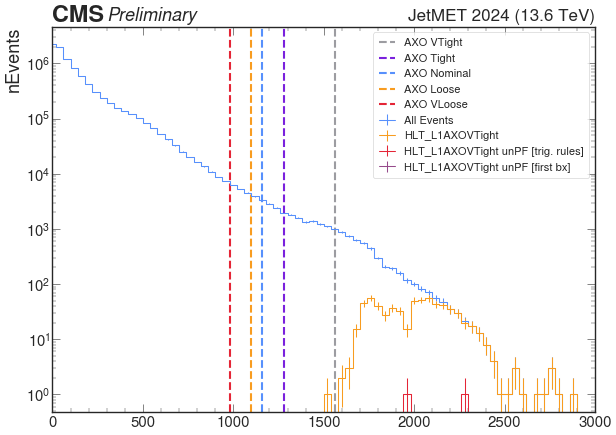

In [26]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

fig, ax = plt.subplots(figsize=(14,10))
norm = False
hep.cms.label('Preliminary', data=True, lumi=None, year='JetMET 2024', com=13.6)

draw_hist1d(getHist(hist_result, histpath+['anomaly_score']), ax, label='All Events', rebin=1, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+['anomaly_score_'+trigger]), ax, label=trigger, rebin=1, norm=norm)
    draw_hist1d(getHist(hist_result, histpath+['anomaly_score_unpf_'+trigger]), ax, label=trigger+' unPF [trig. rules]', rebin=1, norm=norm)
    draw_hist1d(getHist(hist_result, histpath+['anomaly_score_unpf_firstbx_'+trigger]), ax, label=trigger+' unPF [first bx]', rebin=1, norm=norm)

draw_thresholds(ax, thresholds)

# ax.set_ylim(1E-8, .1)
ax.set_xlim(0, 3000)
ax.set_yscale('log')
ax.set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax.legend(frameon=True, fontsize=16);

## Event-Level Kinematic Plots

### L1 Objects

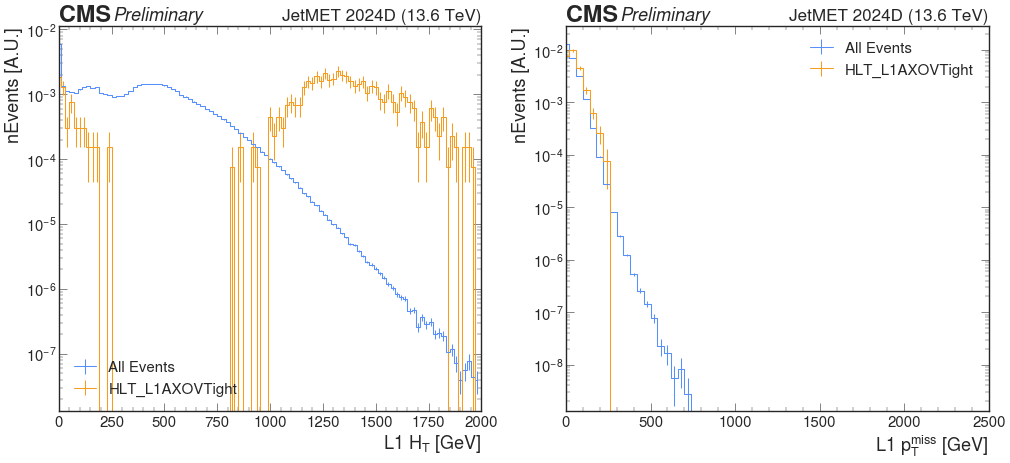

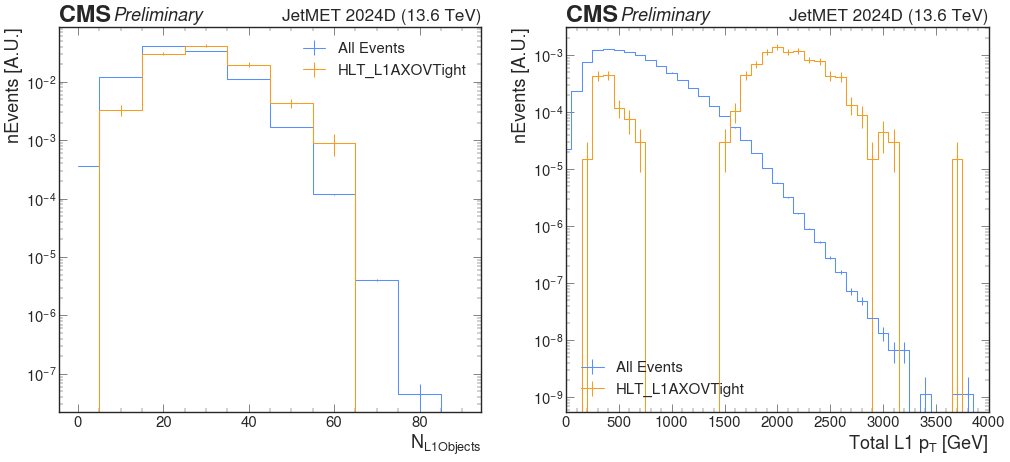

In [27]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# HT
get_name = lambda suf=None: f'l1ht_{suf}' if suf else f'l1ht'
norm = True

draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=1, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger, rebin=1, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'L1 $H_{T}$ [GeV]', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# MET
get_name = lambda suf=None: f'l1met_{suf}' if suf else f'l1met'
norm = 1

draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger, rebin=4, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,2500)
ax[1].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'L1 $p^{miss}_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# Total Object Multiplicity
get_name = lambda suf=None: f'total_l1mult_{suf}' if suf else f'total_l1mult'
norm = True

draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[0], label='All Events', rebin=10, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[0], label=trigger, rebin=10, norm=norm)

hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
# ax[0].set_xlim(0,2000)
ax[0].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax[0].set_xlabel(r'$N_{L1 Objects}$', loc='right')
ax[0].set_yscale('log')
ax[0].legend();

# Total Object Pt
get_name = lambda suf=None: f'total_l1pt_{suf}' if suf else f'total_l1pt'
norm = 1

draw_hist1d(getHist(hist_result, histpath+[get_name(None)]), ax[1], label='All Events', rebin=4, norm=norm)
for trigger in triggers:
    draw_hist1d(getHist(hist_result, histpath+[get_name(trigger)]), ax[1], label=trigger, rebin=4, norm=norm)
            
hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
ax[1].set_xlim(0,4000)
ax[1].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
ax[1].set_xlabel(r'Total L1 $p_{T}$ [GeV]', loc='right')
ax[1].set_yscale('log')
ax[1].legend();

## Object-Level Kinematic Plots

### L1 Objects

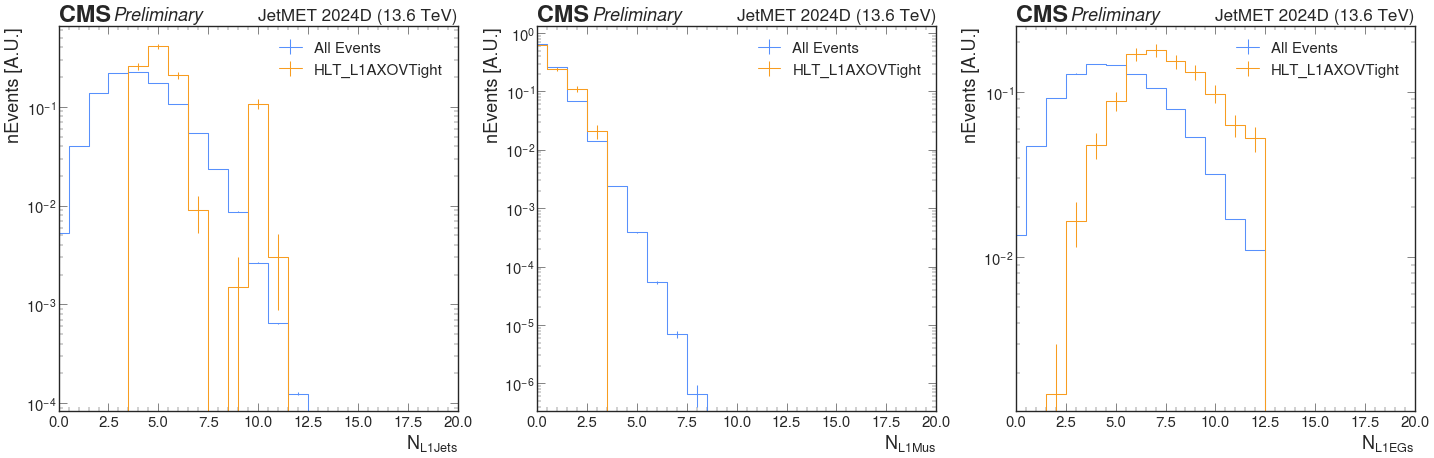

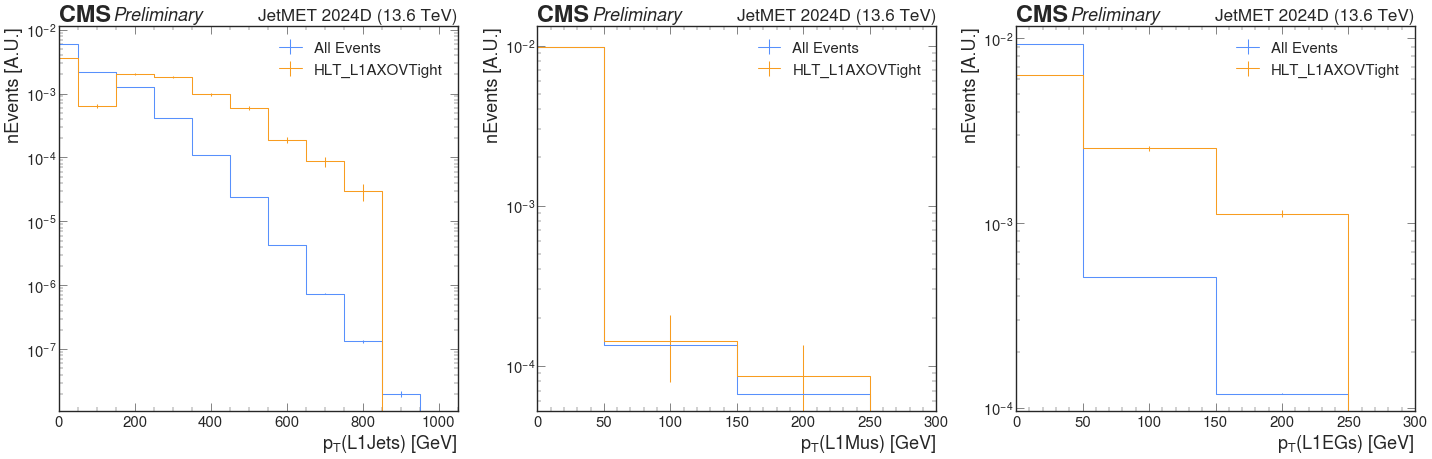

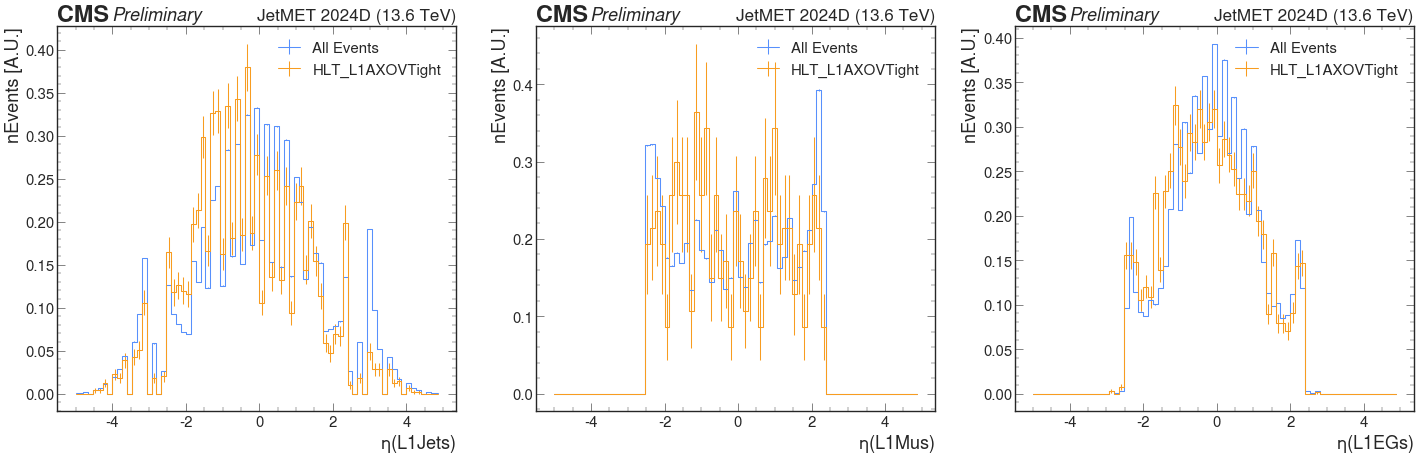

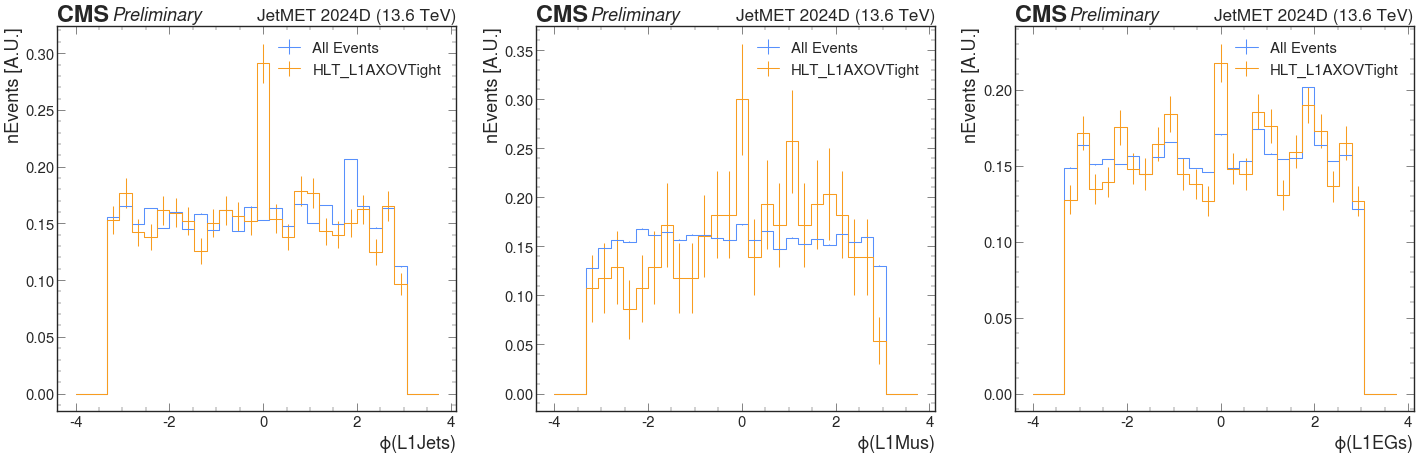

In [28]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']
norm = True

# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20), (0,20)]
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=1, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1050), (0,300), (0,300)]
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=4, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=4, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=2, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

### RECO Objects

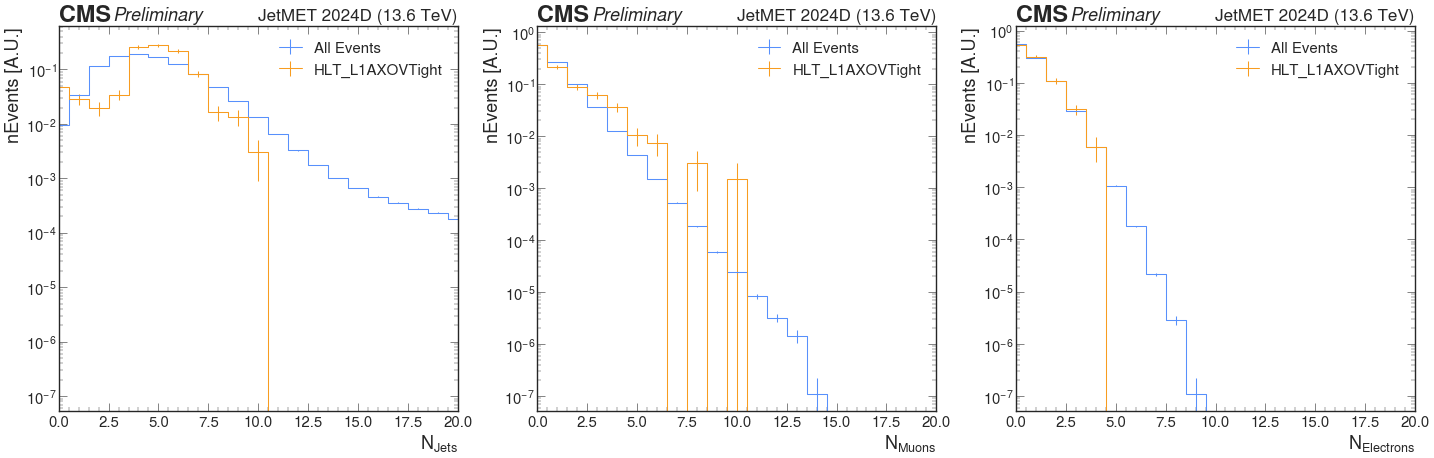

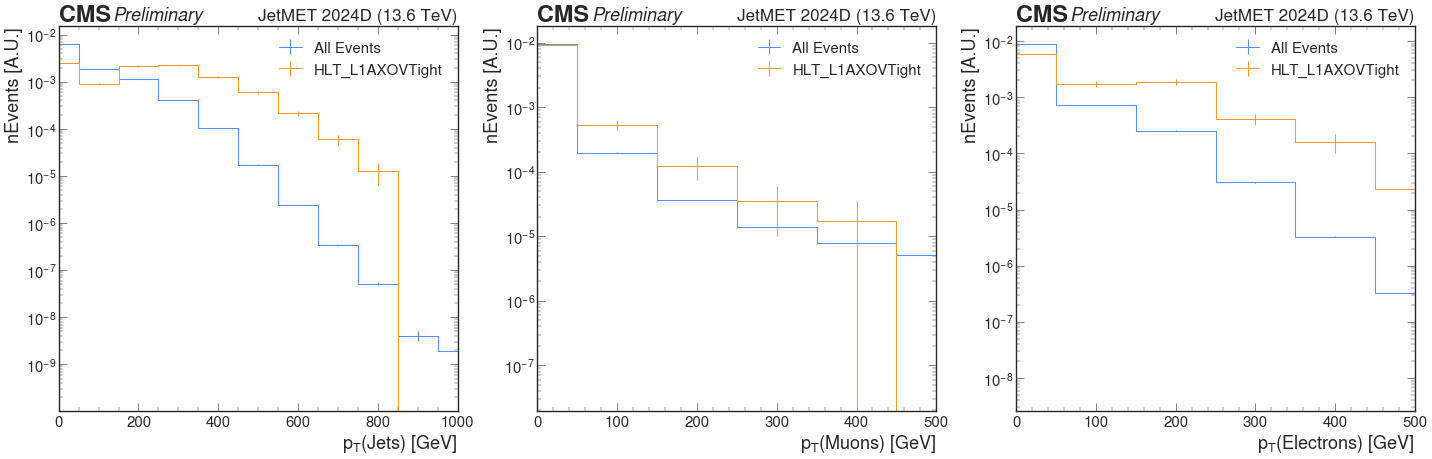

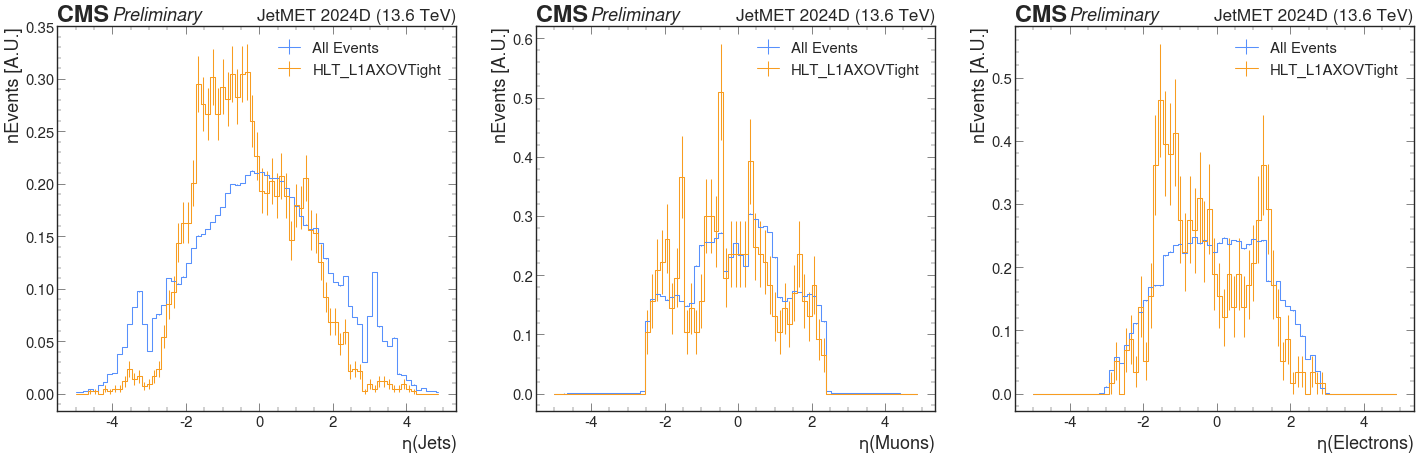

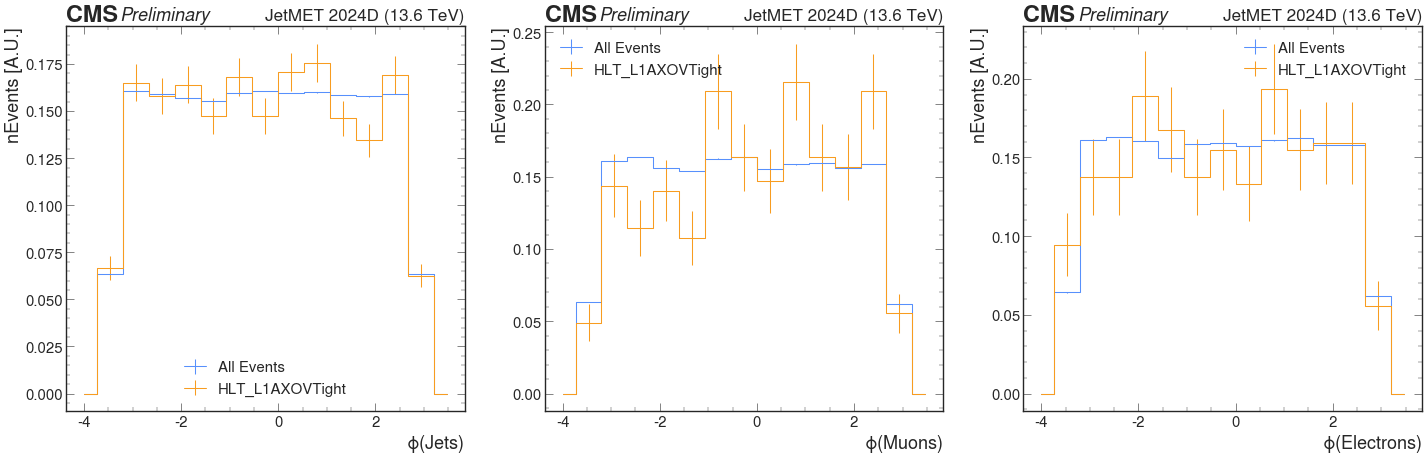

In [29]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

# Multiplicity
get_name = lambda s, suf=None: f'n_{obj}_{suf}' if suf else f'n_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20), (0,20)]
norm = True
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=1, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=1, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Pt
get_name = lambda s, suf=None: f'pt_{obj}_{suf}' if suf else f'pt_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1000), (0,500), (0,500)]
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=4, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=4, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()


# Eta  
get_name = lambda s, suf=None: f'eta_{obj}_{suf}' if suf else f'eta_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=2, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()


# Phi
get_name = lambda s, suf=None: f'phi_{obj}_{suf}' if suf else f'phi_{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=2, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=2, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

## Di-Object Mass Plots

### L1 Objects

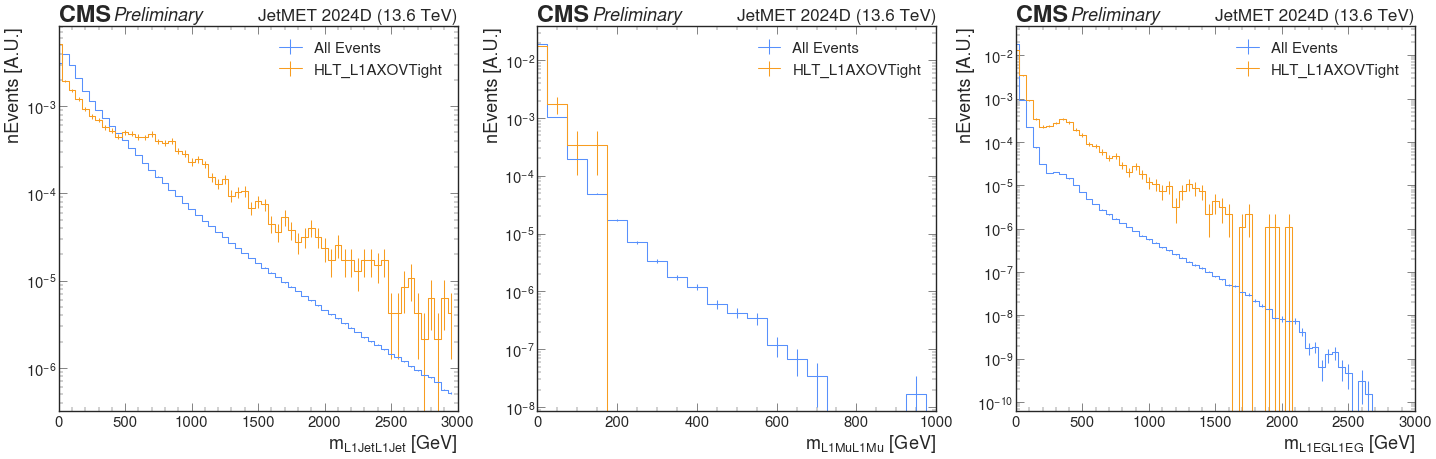

In [30]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,3000), (0,1000), (0,3000)]
norm = True
for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=10, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=10, norm=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()

### RECO Objects

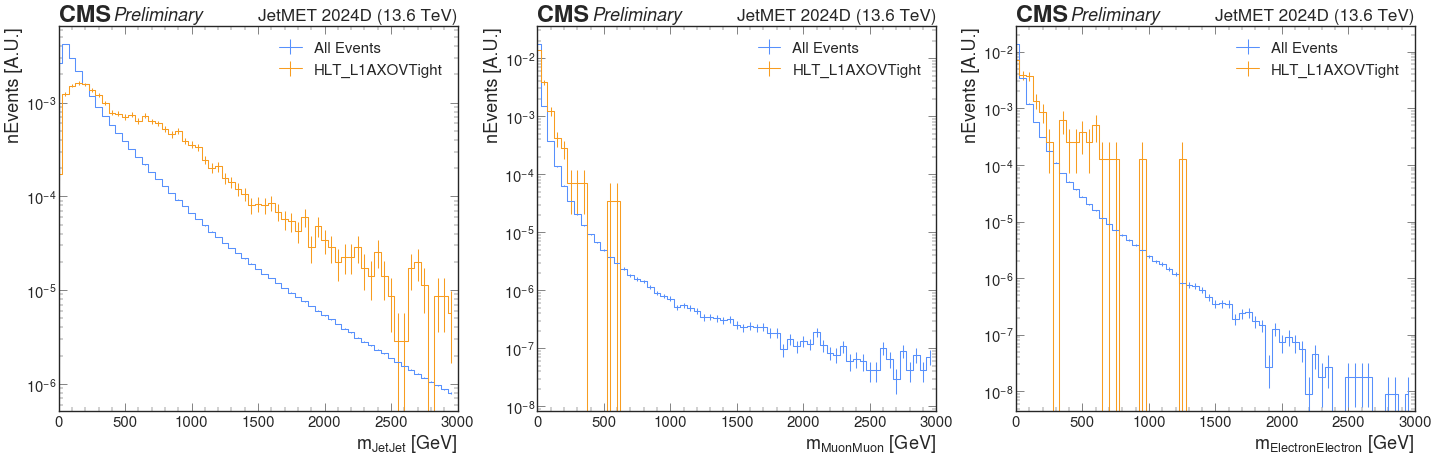

In [31]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

get_name = lambda s, suf=None: f'm{obj}{obj}_{suf}' if suf else f'm{obj}{obj}'
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,3000), (0,3000), (0,3000)]
norm = True
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    draw_hist1d(getHist(hist_result, histpath+[get_name(obj,None)]), ax[i], label='All Events', rebin=10, norm=norm)
    for trigger in triggers:
        draw_hist1d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], label=trigger, rebin=10, norm=norm)
    
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj}{obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()

## 2D Correlation Plots

### L1 Objects

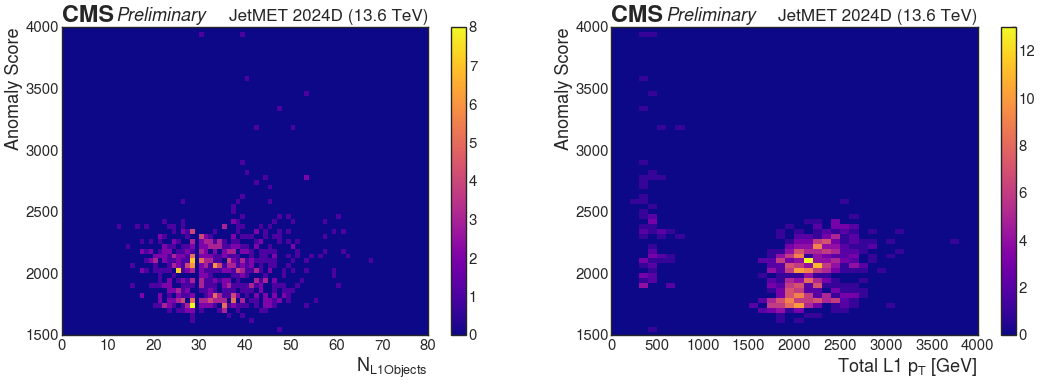

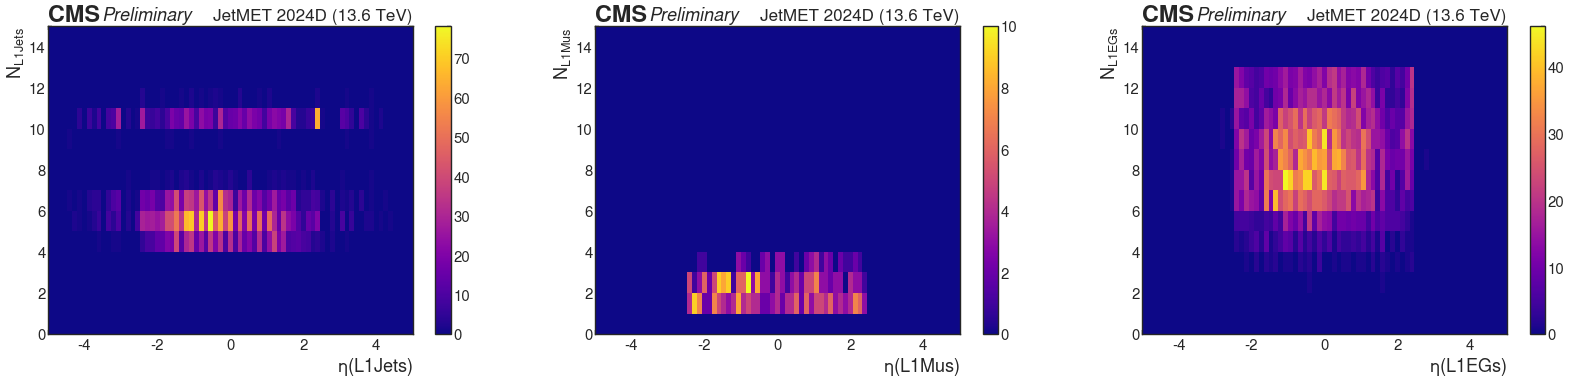

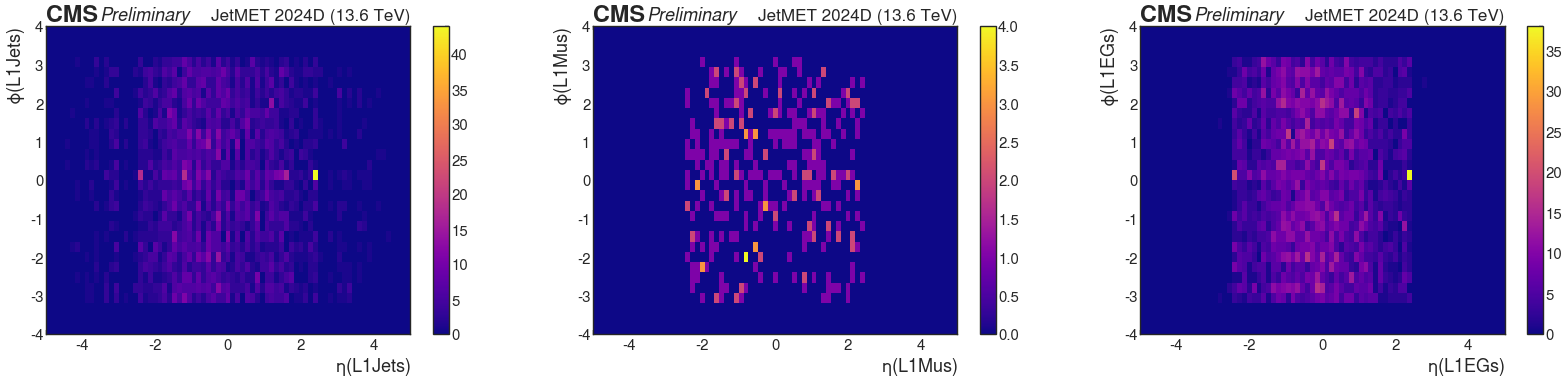

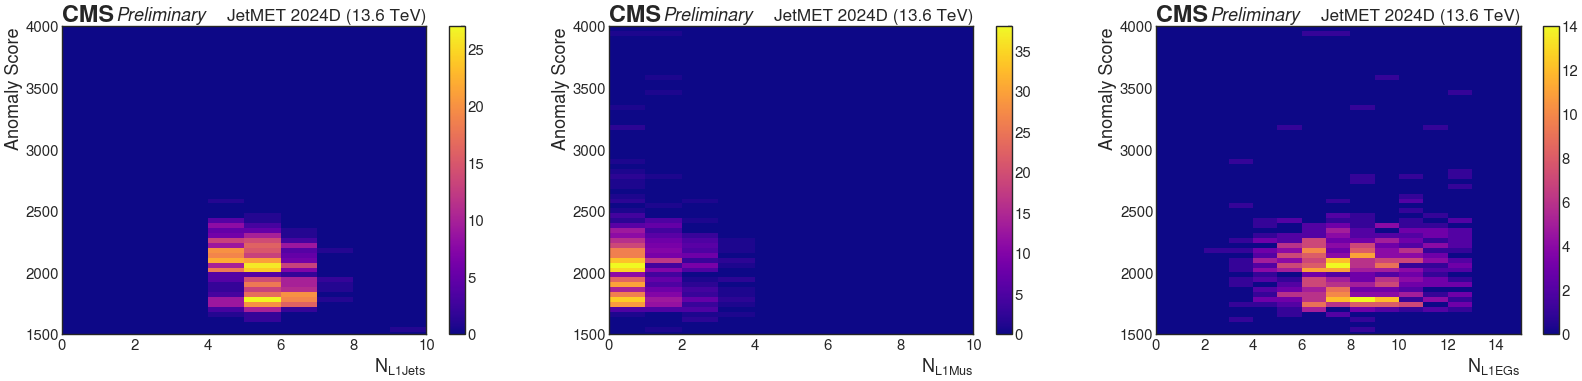

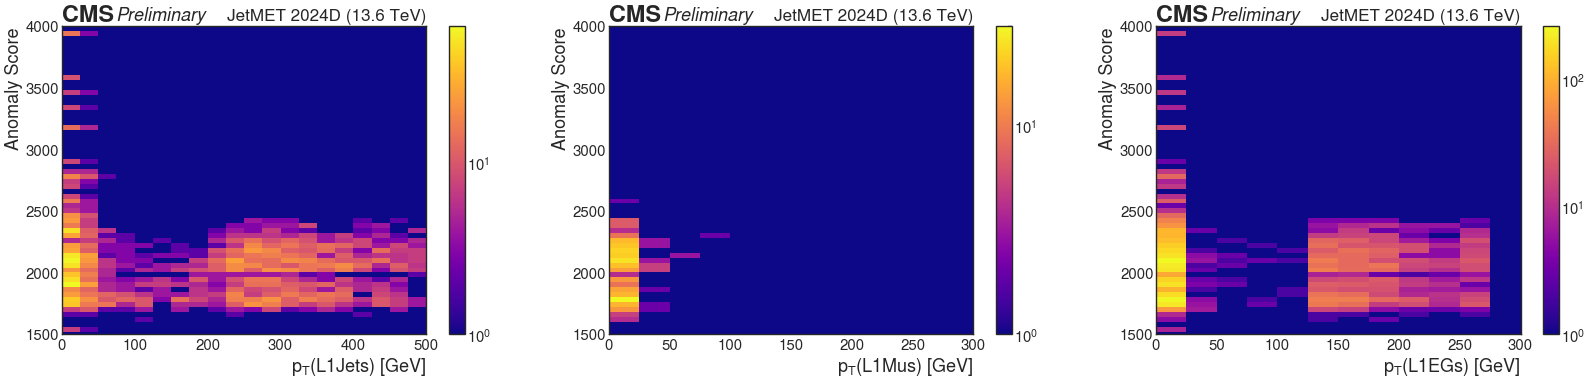

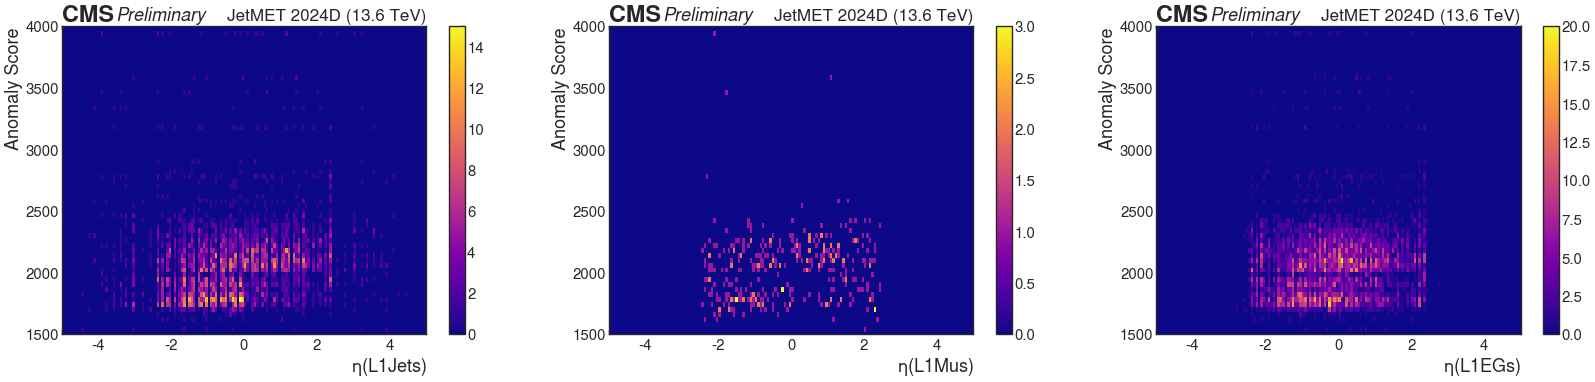

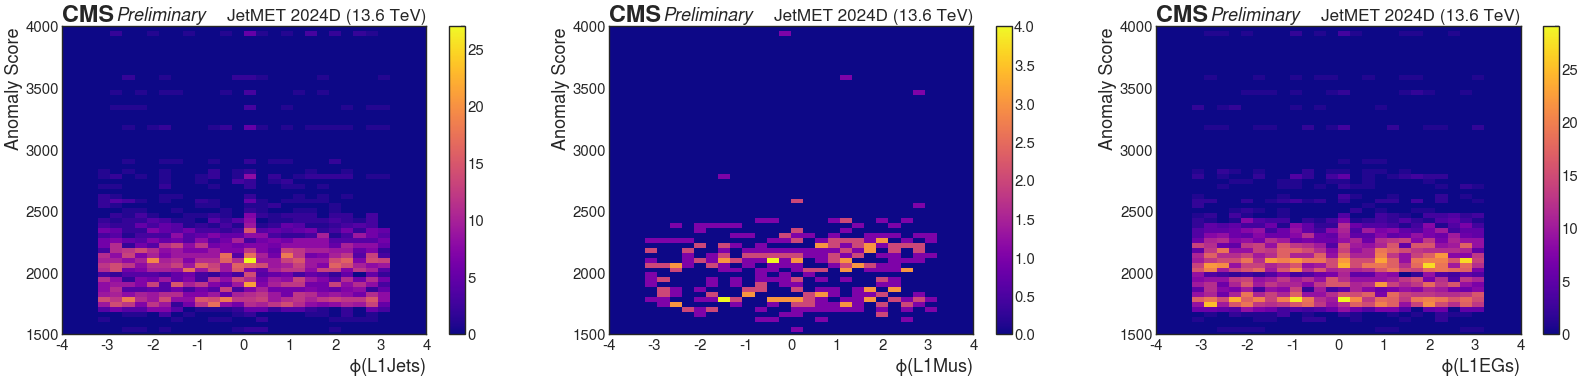

In [32]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']

for trigger in triggers:
    fig, ax = plt.subplots(1, 2, figsize=(26, 8))

    #  Score vs. Total Multiplicity
    get_name = lambda s, suf=None: f'anomaly_score_total_mult_{suf}' if suf else f'anomaly_score_total_mult'
    xrange = (0,80)
    yrange = (1500,4000)
    norm = False

    mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[0], 'mult','score', x_rebin=1, y_rebin=1, norm=False)

    hep.cms.label('Preliminary', ax=ax[0], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[0].set_xlim(*xrange)
    ax[0].set_ylim(*yrange)
    ax[0].set_xlabel(r'$N_{L1 Objects}$', loc='right')
    ax[0].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)

    #  Score vs. Total Pt
    get_name = lambda s, suf=None: f'anomaly_score_total_pt_{suf}' if suf else f'anomaly_score_total_pt'
    xrange = (0,4000)
    yrange = (1500,4000)
    norm = False

    mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[1], 'pt','score', x_rebin=1, y_rebin=4, norm=False)

    hep.cms.label('Preliminary', ax=ax[1], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[1].set_xlim(*xrange)
    ax[1].set_ylim(*yrange)
    ax[1].set_xlabel(r'Total L1 $p_{T}$ [GeV]', loc='right')
    ax[1].set_ylabel('Anomaly Score', loc='top')
    fig.colorbar(mesh)


    # Mult vs. Eta
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'n_eta_{obj}_{suf}' if suf else f'n_eta_{obj}'
    # xrange = [(0,10), (0,10), (0,15)]
    yrange = [(0,15), (0,15), (0,15)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','mult', x_rebin=1, y_rebin=2, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$N_{{{obj+"s"}}}$', loc='top')
        fig.colorbar(mesh)

    # Eta vs. Phi
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
    # xrange = [(0,10), (0,10), (0,15)]
    # yrange = [(1500,4000), (980,4000), (980,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','phi', x_rebin=2, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        # ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
        fig.colorbar(mesh)

    # Score vs. Multiplicity
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
    xrange = [(0,10), (0,10), (0,15)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'mult','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

    #  Score vs. Pt
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
    xrange = [(0,500), (0,300), (0,300)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'pt','score', x_rebin=1, y_rebin=1, norm=True)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

    #  Score vs. Eta
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
    # xrange = [(0,4000), (0,4000), (0,4000)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)


    #  Score vs. Phi
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
    # xrange = [(0,4000), (0,4000), (0,4000)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['L1Jet', 'L1Mu', 'L1EG']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'phi','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

### RECO Objects

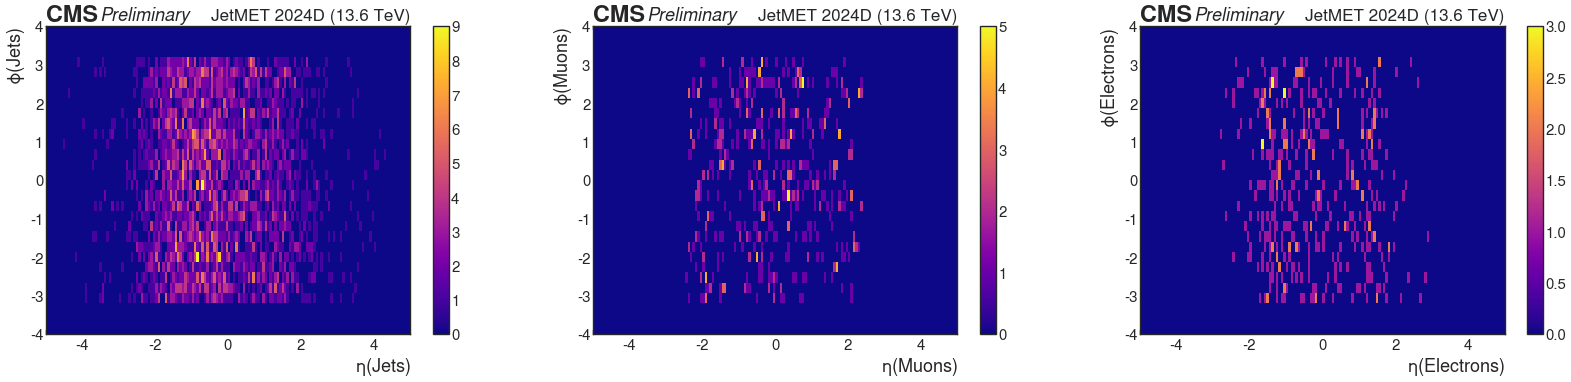

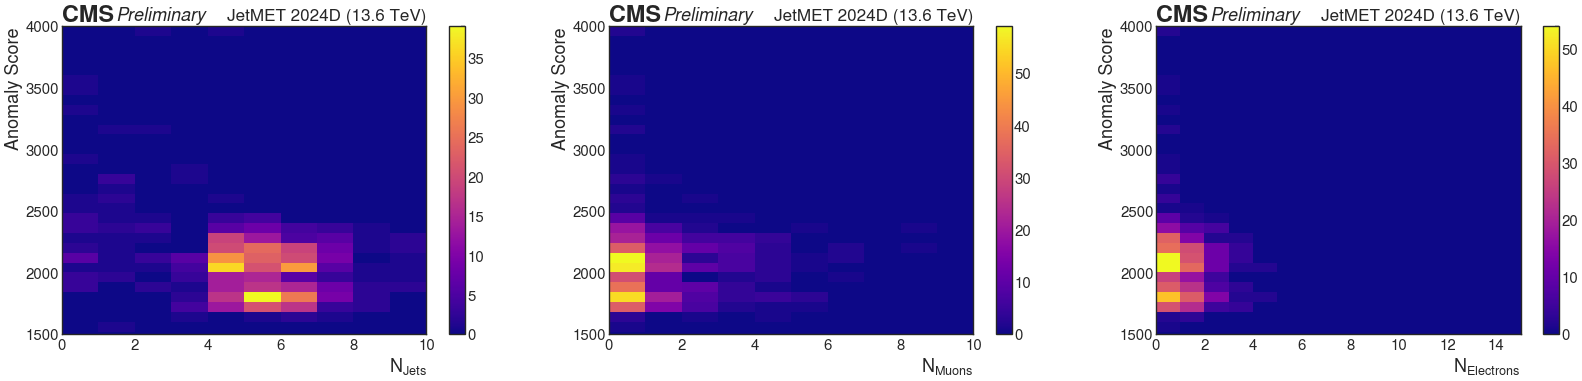

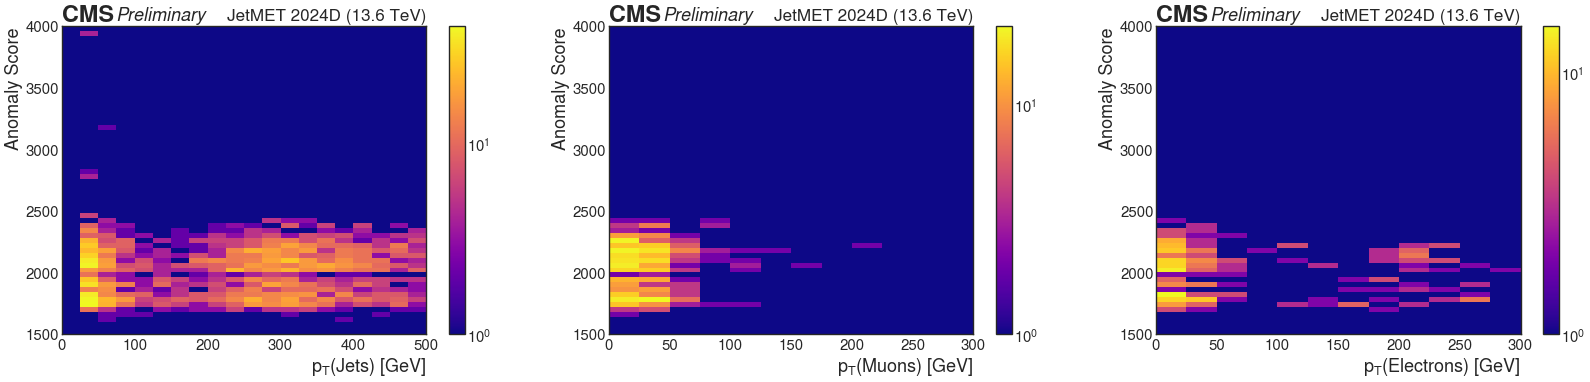

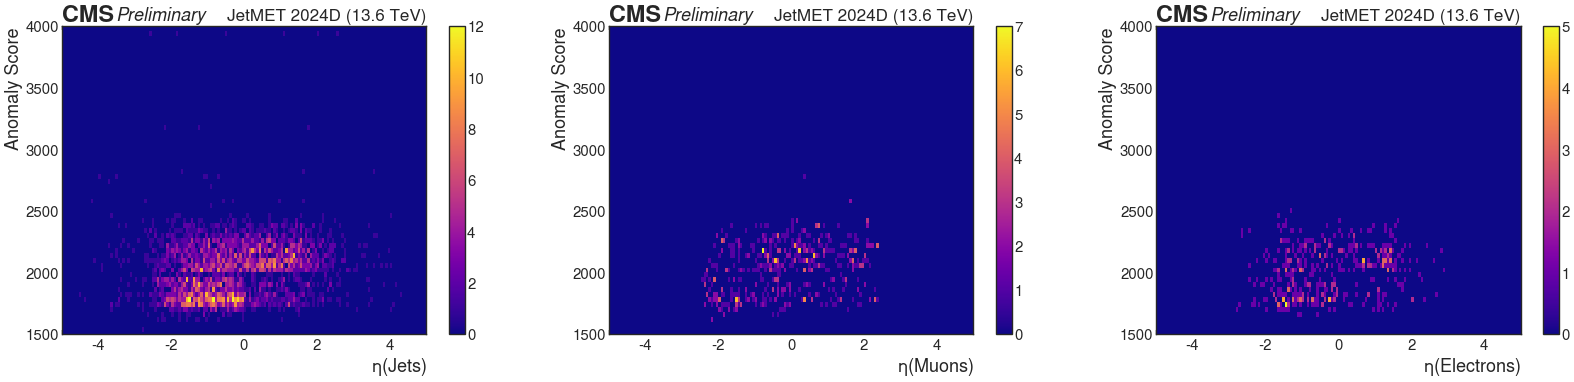

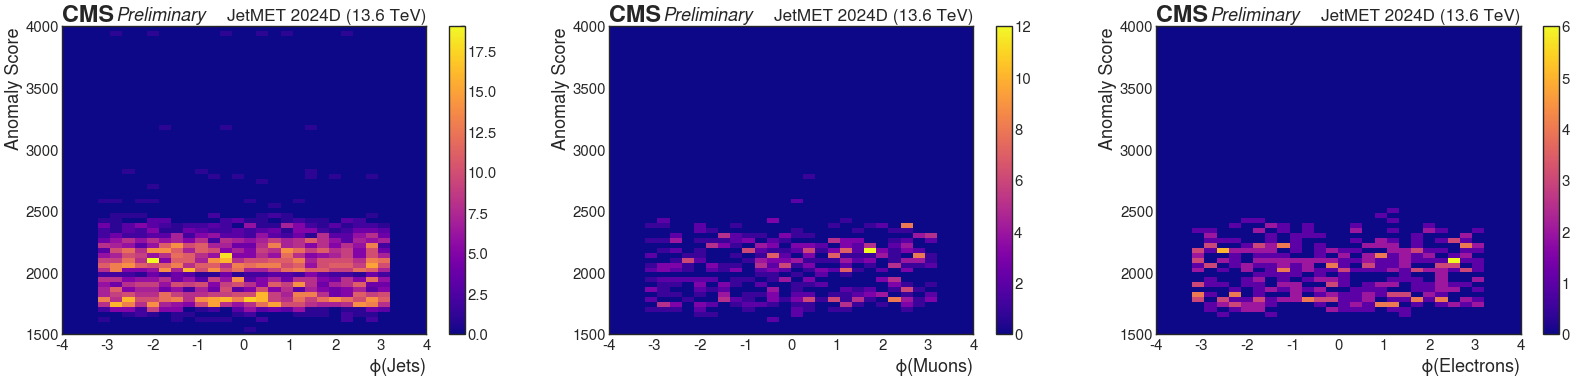

In [33]:
histpath = ['JetMET_2024D_wScores','hists']
triggers = ['HLT_L1AXOVTight']
cmap = plt.get_cmap('plasma')

for trigger in triggers:
    # Eta vs. Phi
    get_name = lambda s, suf=None: f'eta_phi_{obj}_{suf}' if suf else f'eta_phi_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    # xrange = [(0,10), (0,10), (0,15)]
    # yrange = [(1500,4000), (980,4000), (980,4000)]
    norm = False
    for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','phi', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        # ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel(f'$\phi({obj+"s"})$', loc='top')
        fig.colorbar(mesh)

    # Score vs. Multiplicity
    get_name = lambda s, suf=None: f'anomaly_score_n_{obj}_{suf}' if suf else f'anomaly_score_n_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    xrange = [(0,10), (0,10), (0,15)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'mult','score', x_rebin=2, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

    #  Score vs. Pt
    get_name = lambda s, suf=None: f'anomaly_score_pt_{obj}_{suf}' if suf else f'anomaly_score_pt_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    xrange = [(0,500), (0,300), (0,300)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'pt','score', x_rebin=1, y_rebin=1, norm=True)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

    #  Score vs. Eta
    get_name = lambda s, suf=None: f'anomaly_score_eta_{obj}_{suf}' if suf else f'anomaly_score_eta_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    # xrange = [(0,4000), (0,4000), (0,4000)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'eta','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

    #  Score vs. Phi
    get_name = lambda s, suf=None: f'anomaly_score_phi_{obj}_{suf}' if suf else f'anomaly_score_phi_{obj}'
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    # xrange = [(0,4000), (0,4000), (0,4000)]
    yrange = [(1500,4000), (1500,4000), (1500,4000)]
    norm = False
    for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
        mesh = draw_hist2d(getHist(hist_result, histpath+[get_name(obj,trigger)]), ax[i], 'phi','score', x_rebin=1, y_rebin=1, norm=False)

        hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year=histpath[0].rstrip('_wScores').replace('_', ' '), com=13.6)
        # ax[i].set_xlim(*xrange[i])
        ax[i].set_ylim(*yrange[i])
        ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
        ax[i].set_ylabel('Anomaly Score', loc='top')
        fig.colorbar(mesh)

# Testing

In [45]:
import uproot as ur
fname = 'root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2024_Data_Production-wScores/CRAB_UserFiles/crab_JetMET_Run2024D_PromptReco_v1_Run380349/240509_155442/0000/L1Nano_wScores_43.root'
f = ur.open(f'{fname}:Events')
# [k for k in f.keys() if (('L1_' not in k) and ('HLT_' not in k))]

events = NanoEventsFactory.from_root(
    {fname:"Events"},
    schemaclass=NanoAODSchema,
).events()

In [49]:
[k for k in f.keys() if ('L1EtSum' in k)]

['nL1EtSum',
 'L1EtSum_bx',
 'L1EtSum_etSumType',
 'L1EtSum_hwPhi',
 'L1EtSum_hwPt',
 'L1EtSum_phi',
 'L1EtSum_pt']